In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
BATCH_SIZE = 128
IMAGE_SIZE = 784
CHANNELS = 1
CLASSES = 10
EPOCHS = 5
LR = 2e-4

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [4]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [5]:
root = 'dataset/'
train = MNIST(root, train=True,  transform=data_transform, download=True)
test = MNIST(root, train=False, transform=data_transform, download=True)

In [6]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
class SimpleNet(nn.Module):
    def __init__(self, image_size, classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(image_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, classes)
        )
    
    def forward(self, x):
        return self.net(x)

In [8]:
def train(model, optimizer, criterion, loader, epochs, device, net_type='fc'):
    history = []
    model.train()
    for i in tqdm(range(epochs)):
        for x, y in tqdm(loader):
            if net_type == 'fc':
                x = x.view(x.shape[0], -1)
            x = x.to(device)
            y = y.to(device)
            
            y_pred = model(x)
            
            loss = criterion(y_pred, y)
            history.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
    return history

In [9]:
def test(model, loader, device, net_type='fc'):
    acc = 0
    batches = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            if net_type == 'fc':
                x = x.view(x.shape[0], -1)
            x = x.to(device)
            y = y.to(device)
            
            y_pred = torch.argmax(model(x), dim=1)
            acc += (y_pred == y).cpu().numpy().mean()
            batches += 1
    return acc / batches

In [10]:
model = SimpleNet(IMAGE_SIZE, CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.99))

In [11]:
history = train(model, optimizer, criterion, train_loader, EPOCHS, device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

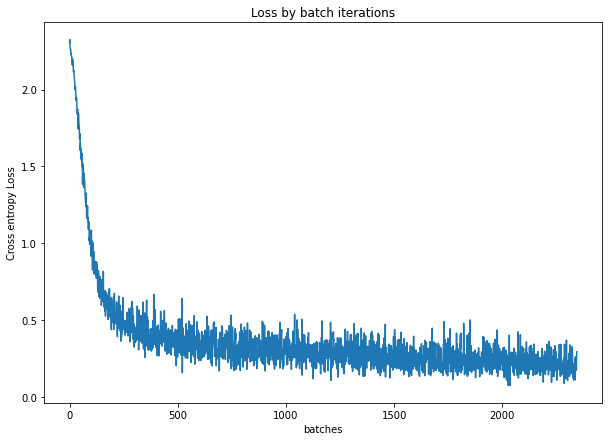

In [12]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Cross entropy Loss')
plt.xlabel('batches')

plt.show()

In [13]:
accuracy = test(model, test_loader, device)
print(f'Test accuracy of fully-connected net {accuracy:.3}')

Test accuracy of fully-connected net 0.939


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(4 * 4 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, classes)
        )
    
    def forward(self, x):
        return self.net(x)

In [15]:
model = SimpleCNN(CHANNELS, CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.99))

In [16]:
history = train(model, optimizer, criterion, train_loader, EPOCHS, device, 'cnn')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

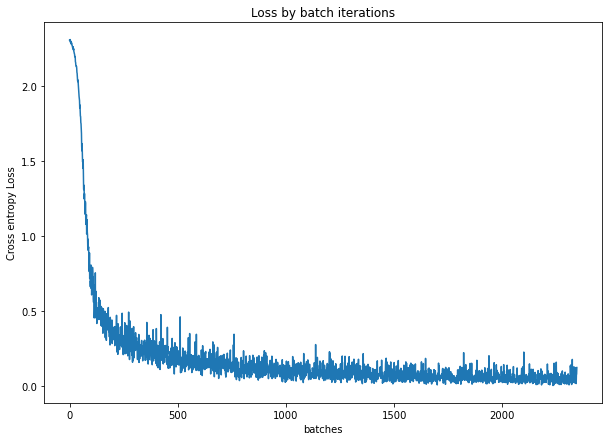

In [17]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Cross entropy Loss')
plt.xlabel('batches')

plt.show()

In [18]:
accuracy = test(model, test_loader, device, 'cnn')
print(f'Test accuracy of CNN {accuracy:.3}')

Test accuracy of CNN 0.986
